In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import simulator_BC as sim_bc
import simulator_BC_evidences as sim_bc_e
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.loss_functions.msm import MethodOfMomentsLoss
from msm_first_moments import MethodOfMomentsLoss_4Moments, MethodOfMomentsLoss_9Moments
from black_it.samplers.random_uniform import RandomUniformSampler
from typing import Sequence
import os
import contextlib
from scipy.special import expit
import torch
import importlib
from tqdm import tqdm
from time import time
import calibration_simple_BC as cal_bc
import simulator_BC_coo as sim_coo
from scipy.special import expit as sigmoid

In [17]:
class BC_simulator_hidden_mu():
    def __init__(self, X0, edges, N, real_mu, real_epsilon, rho = 70, seed = 1):
        self.X0 = np.array(X0).copy()
        self.N = N
        self.edges = edges.clone().long()
        _, edge_per_t, _ = edges.shape
        self.real_mu = real_mu
        self.real_epsilon = real_epsilon
        self.rho = rho
        self.seed = seed
        self.mean_s = np.atleast_2d(edges[:,:,2].sum(dim = 1) / edge_per_t).T
    
    def simulate_mean_s(self, theta, N = 200, seed = None):
        epsilon, mu = theta
        mean_s_pred = []
        
        
        if seed != None:
            np.random.seed(self.seed)
        
        X_t = self.X0.copy()
        diff_X = self.X0[:,None] - self.X0[None,:]
        
        T, edge_per_t, _ = self.edges.size()
        
        for t in range(T):
            u,v,s_obs = self.edges[t].T
            
            s_pred = (np.random.random(edge_per_t) < sigmoid(self.rho * (epsilon - np.abs(diff_X[u,v])))) + 0.
            new_X_t, diff_X = sim_coo.opinion_update(diff_X, X_t, u, v, s_pred, self.N, mu)
            
            X_t = new_X_t.copy()
            
            mean_s_pred.append(s_pred.mean())
            
            X_t  = np.clip(X_t, 10e-5, 1 - 10e-5)
        return np.atleast_2d(mean_s_pred).T

def calibrate_epsilon_BC_hidden_mu(simulator, plot_loss = True, calibration_batches = 100, ensemble_size = 3,
                                   sampler = HaltonSampler, loss = MethodOfMomentsLoss(), batch_size = 1, compare_all_s = False,
                                   parameters_bounds = [[0., 0.], [0.5, 1.]], precisions = [0.0001, 0.01], return_time = False):
    
    t0 = time()
    model = simulator.simulate_mean_s
    real_data = simulator.mean_s
    
    samplers = [sampler(batch_size)]


    BC_cal = Calibrator(real_data = real_data,
                        samplers = samplers,
                        loss_function = loss,
                        model = model,
                        parameters_bounds = parameters_bounds,
                        parameters_precision = precisions,
                        ensemble_size = ensemble_size,
                        saving_folder = None,
                        verbose = False,
                        n_jobs = 1#'initial_state'
                       )
    
    
    params, losses = BC_cal.calibrate(calibration_batches)
    epsilon_sim, mu_sim = params.T
    
    loss_df = pd.DataFrame({"epsilon": epsilon_sim, "mu": mu_sim, "loss": losses}).sort_values("loss")
    
    

    estimated_epsilon, estimated_mu, _ = loss_df.iloc[0]
    t1 = time()
    calibration = {"loss": loss_df, "estimation": (estimated_epsilon, estimated_mu)}
    
    if return_time:
        calibration["time"] = t1-t0
    
    return calibration


In [18]:
N, T, edge_per_t = 100, 100, 1
epsilon, mu = 0.2, 0.2

calibration_batches = 100


X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)

simulator = BC_simulator_hidden_mu(X[0], edges, N, mu, epsilon, rho = 70)


calibrated_epsilon = calibrate_epsilon_BC_hidden_mu(simulator, calibration_batches = calibration_batches,
                                                      loss = MethodOfMomentsLoss_9Moments(),
                                                      ensemble_size = 1, return_time = True)


<AxesSubplot:xlabel='epsilon', ylabel='loss'>

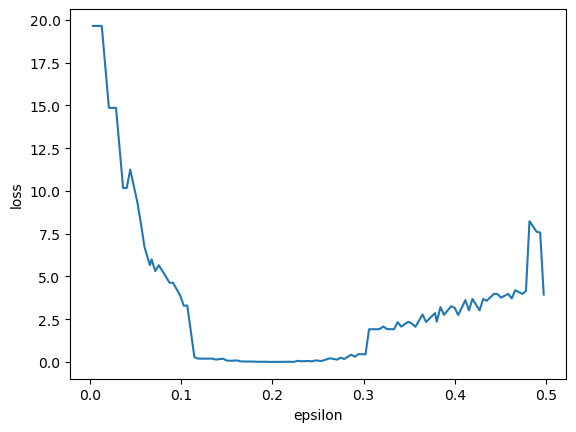

In [19]:
sns.lineplot(data = calibrated_epsilon["loss"], x = "epsilon", y = "loss")

<AxesSubplot:xlabel='mu', ylabel='loss'>

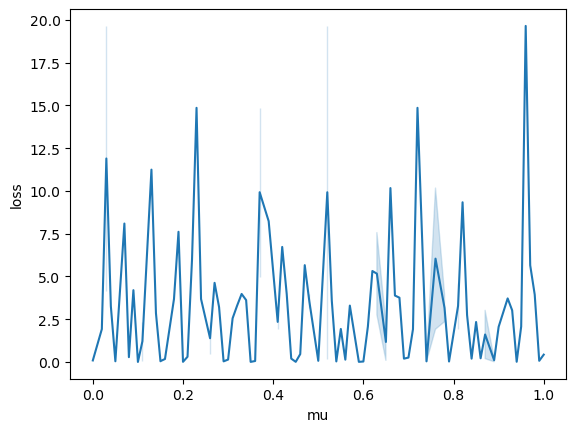

In [20]:
sns.lineplot(data = calibrated_epsilon["loss"], x = "mu", y = "loss")

In [146]:
def repeat_simulations_random(tot_simulations, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                              ensemble_size_list, calibration_batches_list, sum_ab_list, evidences_per_t_list,
                              loss = MethodOfMomentsLoss_4Moments, ensemble_size = 1,
                              sampler = HaltonSampler, verbose = True):
    
    simulations = []
    for _ in tqdm(range(tot_simulations), disable = not verbose):
        np.random.seed(_ + 40)
        T, N, edge_per_t, epsilon, mu, ensemble_size,\
        calibration_batches, sum_ab, evidences_per_t = np.random.choice(T_list), np.random.choice(N_list),\
        np.random.choice(edge_per_t_list), np.random.choice(epsilon_list), np.random.choice(mu_list),\
        np.random.choice(ensemble_size_list), np.random.choice(calibration_batches_list),\
        np.random.choice(sum_ab_list), np.random.choice(evidences_per_t_list)
        
        X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)
        
        simulator = BC_simulator_hidden_mu(X[0], edges, N, mu, epsilon, rho = 70)
        
        
        calibrated_epsilon = calibrate_epsilon_BC_hidden_mu(simulator, calibration_batches = calibration_batches,
                                                            loss = loss, sampler = sampler,
                                                            ensemble_size = ensemble_size, return_time = True)

        
        _, (epsilon_sim, mu_sim), time_sim = calibrated_epsilon.values()
        
        simulations.append([epsilon_sim, np.abs(epsilon - epsilon_sim),mu_sim, np.abs(mu - mu_sim),\
                            time_sim, epsilon, mu, T, N, edge_per_t, ensemble_size,\
                            calibration_batches])
                    
    return pd.DataFrame(simulations, columns = ["epsilon", "distance_epsilon", "mu", "distance_mu",\
                            "time", "real_epsilon", "real_mu", "T", "N", "edge_per_t", "ensemble_size",\
                            "calibration_batches"])

### Compare moments and loss

In [119]:
simulations = []
repetitions = 50
T, N, edge_per_t = 100, 100, 4

for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random() / 2, np.random.random()
    X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)
    simulator = BC_simulator_hidden_mu(X[0], edges, N, mu, epsilon, rho = 70)
    
    
    for sampler_name, sampler in zip(["halton", "random"],[HaltonSampler, RandomUniformSampler]):
   
        for loss_name, loss in zip(["4_moments", "9_moments", "all_moments"],
                                   [MethodOfMomentsLoss_4Moments(), MethodOfMomentsLoss_9Moments(), MethodOfMomentsLoss()]):
            calibrated_epsilon = calibrate_epsilon_BC_hidden_mu(simulator, calibration_batches = calibration_batches,
                                                            loss = loss, sampler = sampler,
                                                            ensemble_size = 1, return_time = True)
            
            _, (epsilon_sim, mu_sim), time_sim = calibrated_epsilon.values()
            
            simulations.append([epsilon, mu, epsilon_sim, mu_sim, np.abs(epsilon - epsilon_sim), 
                               np.abs(mu - mu_sim), time_sim, loss_name, sampler_name])
        
            
        
        


100%|██████████████████████████████████████████████████████████████████| 50/50 [1:28:23<00:00, 106.06s/it]


In [120]:
simulations_loss_sampler = pd.DataFrame(simulations, columns = ["epsilon", "mu", "epsilon_sim", "mu_sim", "distance_epsilon", 
                                                                "distance_mu", "time_sim", "loss_name", "sampler"])

In [121]:
simulations_loss_sampler.to_csv(f"/home/jacopo.lenti/Projects/learning-od-step-by-step/data/calibrations_loss_sampler_hidden_mu_230619.csv")


<AxesSubplot:xlabel='sampler', ylabel='loss_name'>

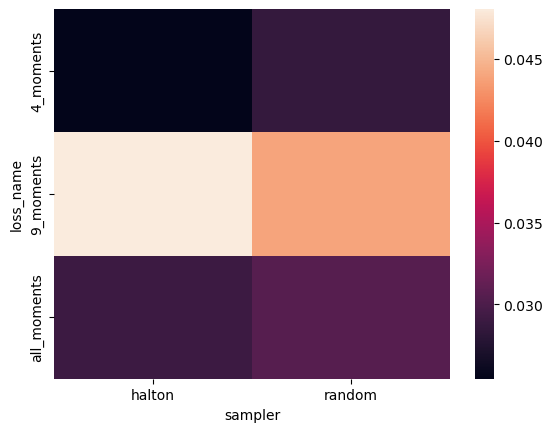

In [122]:
sns.heatmap(simulations_loss_sampler.groupby(["loss_name", "sampler"]).mean()["distance_epsilon"].unstack())

### Compare ensemble_size and ensemble_batches

In [137]:
simulations = []
repetitions = 20
sampler = HaltonSampler

loss = MethodOfMomentsLoss_4Moments()
T, N, edge_per_t = 100, 100, 4

for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random() / 2, np.random.random()
    X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)
    simulator = BC_simulator_hidden_mu(X[0], edges, N, mu, epsilon, rho = 70)
    
    
    for calibration_batches in [50, 100, 200]:
        for ensemble_size in [1,2,4]:
            calibrated_epsilon = calibrate_epsilon_BC_hidden_mu(simulator, calibration_batches = calibration_batches,
                                                            loss = loss, sampler = sampler,
                                                            ensemble_size = ensemble_size, return_time = True)
            
            _, (epsilon_sim, mu_sim), time_sim = calibrated_epsilon.values()
            
            simulations.append([epsilon, mu, epsilon_sim, mu_sim, np.abs(epsilon - epsilon_sim), 
                               np.abs(mu - mu_sim), time_sim, calibration_batches, ensemble_size])
        
            
        
        


100%|██████████████████████████████████████████████████████████████████| 20/20 [1:11:44<00:00, 215.25s/it]


In [138]:
simulation_batches = pd.DataFrame(simulations, columns = ["epsilon", "mu", "epsilon_sim", "mu_sim", "distance_epsilon", 
                                                                "distance_mu", "time_sim", "calibration_batches", "ensemble_size"])


<AxesSubplot:xlabel='calibration_batches', ylabel='ensemble_size'>

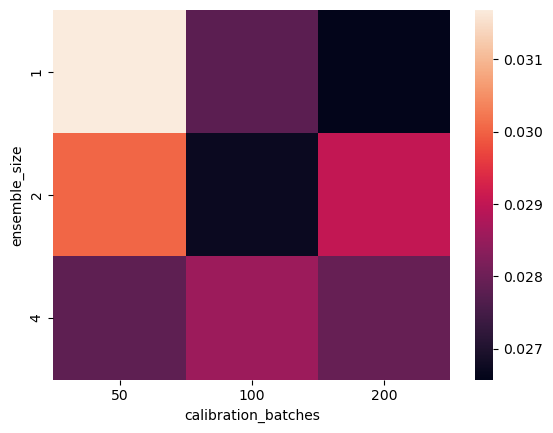

In [139]:
sns.heatmap(simulation_batches.groupby(["ensemble_size", "calibration_batches"]).mean()["distance_epsilon"].unstack())

In [140]:
simulation_batches.groupby(["ensemble_size", "calibration_batches"]).mean()["distance_epsilon"]

ensemble_size  calibration_batches
1              50                     0.031683
               100                    0.027778
               200                    0.026573
2              50                     0.030038
               100                    0.026718
               200                    0.029028
4              50                     0.027828
               100                    0.028553
               200                    0.027913
Name: distance_epsilon, dtype: float64

## Use 4 moments, Halton, 200 simulations (ensemble 1)

In [147]:
T_list = [100] 
N_list = [100]
edge_per_t_list = [1,4,8,16]
epsilon_list = np.arange(0.01, 0.49, 0.04) 
mu_list = np.arange(0.04, 0.99, 0.08)
ensemble_size_list = [1]
calibration_batches_list = [200]
evidences_per_t_list = [5,10,20,40]
sum_ab_list = [0.1, 1, 10]



calibrations_df_fixed = repeat_simulations_random(400, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                                                  ensemble_size_list, calibration_batches_list,
                                                  sum_ab_list, evidences_per_t_list, 
                                                  loss = MethodOfMomentsLoss_4Moments(),
                                                  verbose = True)


100%|█████████████████████████████████████████████████████████████████| 400/400 [1:36:39<00:00, 14.50s/it]


In [2]:
#calibrations_df_fixed.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/calibrations_hidden_mu_230619.csv")
calibrations_df_fixed = pd.read_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/calibrations_hidden_mu_230619.csv", index_col = 0)

In [3]:
calibrations_df_fixed.sort_values("distance_epsilon", ascending = False).head(10)

,epsilon,distance_epsilon,mu,distance_mu,time,real_epsilon,real_mu,T,N,edge_per_t,ensemble_size,calibration_batches
210,0.2665,0.1435,0.68,0.64,13.142599,0.41,0.04,100,100,8,1,200
3,0.1380,0.1280,0.38,0.26,9.836949,0.01,0.12,100,100,1,1,200
95,0.3337,0.1163,0.59,0.33,18.269963,0.45,0.92,100,100,16,1,200
362,0.3591,0.1091,0.97,0.45,16.591804,0.25,0.52,100,100,4,1,200
326,0.4741,0.1041,0.92,0.08,14.685836,0.37,0.84,100,100,16,1,200
212,0.1499,0.1001,0.13,0.31,11.242589,0.25,0.44,100,100,16,1,200
269,0.3855,0.0955,0.01,0.35,15.665243,0.29,0.36,100,100,4,1,200
96,0.4618,0.0918,0.11,0.33,19.676765,0.37,0.44,100,100,16,1,200
347,0.4190,0.0890,0.97,0.05,17.959602,0.33,0.92,100,100,16,1,200
214,0.4556,0.0856,0.97,0.13,14.525584,0.37,0.84,100,100,8,1,200


<AxesSubplot:xlabel='mu', ylabel='real_mu'>

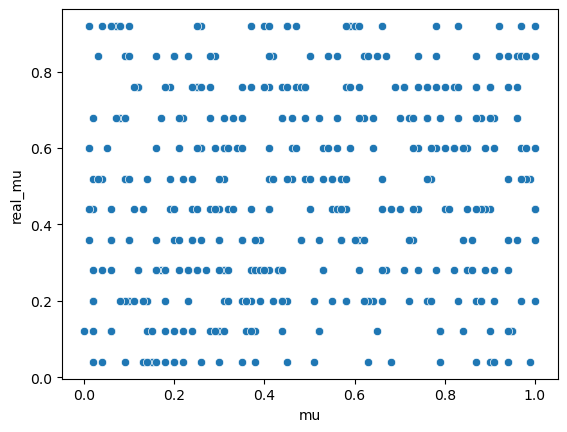

In [7]:
sns.scatterplot(data = calibrations_df_fixed.assign(diff_mu = lambda x: x["mu"] - x["real_mu"]),
                x = "mu", y = "real_mu")

In [6]:
calibrations_df_fixed.assign(diff_mu = lambda x: x["mu"] - x["real_mu"]).mean()

epsilon                  0.237456
distance_epsilon         0.022399
mu                       0.480550
distance_mu              0.295600
time                    14.454090
real_epsilon             0.234100
real_mu                  0.476000
T                      100.000000
N                      100.000000
edge_per_t               7.232500
ensemble_size            1.000000
calibration_batches    200.000000
diff_mu                  0.004550
dtype: float64

In [150]:
calibrations_df_fixed[["time", "distance_epsilon", "distance_mu"]].mean()

time                14.454090
distance_epsilon     0.022399
distance_mu          0.295600
dtype: float64

<AxesSubplot:ylabel='distance_mu'>

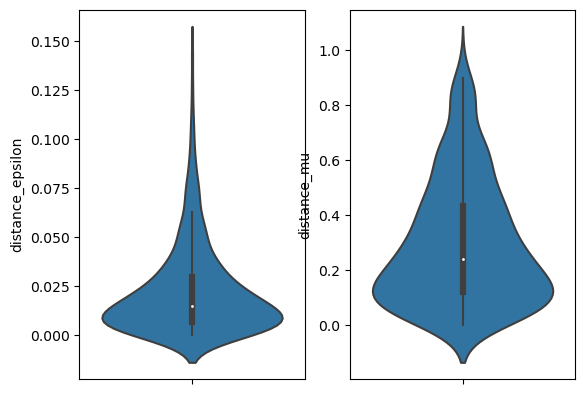

In [151]:
fig, axes = plt.subplots(ncols = 2)
sns.violinplot(y = calibrations_df_fixed["distance_epsilon"], ax = axes[0])
sns.violinplot(y = calibrations_df_fixed["distance_mu"], ax = axes[1])

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_epsilon'>

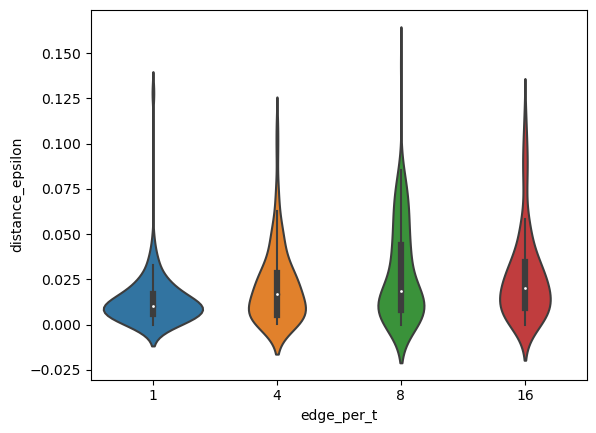

In [152]:
fig, axes = plt.subplots()

sns.violinplot(data = calibrations_df_fixed, x = "edge_per_t", y = "distance_epsilon", ax = axes)

In [155]:
calibrations_df_fixed.groupby("edge_per_t").mean()["distance_epsilon"]

edge_per_t
1     0.013326
4     0.021381
8     0.028356
16    0.026366
Name: distance_epsilon, dtype: float64